In [13]:
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.preprocessing import FunctionTransformer
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer #, IterativeImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler, MaxAbsScaler

from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve, auc, SCORERS
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn import set_config
set_config(display ="diagram")

import matplotlib.pyplot as plt
%matplotlib inline

In [14]:

full_df=pd.read_csv('../data/processed/crashes.gz', compression='gzip', low_memory=False)



In [180]:
all_cols=['GUILTY','DEVICE_CONDITION', 'FIRST_CRASH_TYPE', 'FIRST_CONTACT_POINT', 
           'TRAFFICWAY_TYPE','ROADWAY_SURFACE_COND','VEHICLE_DEFECT', 'ROAD_DEFECT',
             'DRIVERS_LICENSE_CLASS', 'AGE_GROUP', 'VEHICLE_AGE', 'AIRBAG_DEPLOYED',
            'PHYSICAL_CONDITION', 'MANEUVER',  'DRIVER_VISION',  'ALIGNMENT' ,  'TRAFFIC_CONTROL_DEVICE',
                    'NUM_PASSENGERS','VEHICLE_YEAR','AGE','SAFETY_EQUIPMENT','WEATHER_CONDITION','LIGHTING_CONDITION',
                     'VEHICLE_TYPE']

sample_df=full_df[all_cols].sample(100000, random_state=100)

sample_df['NOT_GUILTY'] = (np.where(sample_df['GUILTY'] == 'NO', 1, 0))


In [99]:

y = sample_df['GUILTY']
x = sample_df.drop(['GUILTY'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=43, test_size=0.25, stratify=y)

#X_train=X_train.apply(LabelEncoder().fit_transform)
#X_test=X_test.apply(LabelEncoder().fit_transform)

In [100]:
#numeric_columns = []

nominal_columns = [ 'FIRST_CRASH_TYPE', 'FIRST_CONTACT_POINT', 'MANEUVER' ] 

#X_train = X_train[numeric_columns+nominal_columns]
#X_test = X_test[numeric_columns+nominal_columns]



In [109]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(nominal_columns)),
#        ('imputer', SimpleImputer(strategy = 'most_frequent')),
        ('cat_encoder', OneHotEncoder(sparse=False, handle_unknown =  'ignore' )),
    ])


XGB_pipeline = Pipeline([ ( "cat_pipeline", cat_pipeline ),
                  ('boost', XGBClassifier(use_label_encoder=False, 
                                          eval_metric='auc', gamma= 0.02, max_depth=3, n_estimators=90, n_jobs=-1))
                 ])


pipe_grid={'boost__gamma':[0.01,0.015]}
#pipe_grid={'boost__gamma':[0.01,0.015], 'boost__n_estimators':[110,130,150]}

gs_pipe = GridSearchCV(estimator=XGB_pipeline, param_grid=pipe_grid,  cv=3, scoring='roc_auc')



In [112]:
gs_pipe.fit(X_train, y_train)
#XGB_pipeline.fit(X_train, y_train)




        


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cat_pipeline',
                                        Pipeline(steps=[('selector',
                                                         DataFrameSelector(attribute_names=['FIRST_CRASH_TYPE',
                                                                                            'FIRST_CONTACT_POINT',
                                                                                            'MANEUVER'])),
                                                        ('cat_encoder',
                                                         OneHotEncoder(handle_unknown='ignore',
                                                                       sparse=False))])),
                                       ('boost',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_b...
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_bin=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=3,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=90,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None,
                                                      reg_alpha=None,
                                                      reg_lambda=None, ...))]),
             param_grid={'boost__gamma': [0.01, 0.015]}, scoring='roc_auc')

In [113]:
y_pred_train=gs_pipe.predict(X_train)
y_pred_test=gs_pipe.predict(X_test)

#y_pred_train=XGB_pipeline.predict(X_train)
#y_pred_test=XGB_pipeline.predict(X_test)

In [114]:
#print(XGB_pipeline.score(X_train, y_train ))
print(gs_pipe.score(X_train, y_train ))
print(classification_report(y_train, y_pred_train))
print('------------')
print(classification_report(y_test, y_pred_test))

0.8481859040953137
              precision    recall  f1-score   support

           0       0.82      0.87      0.84     48863
           1       0.73      0.64      0.68     26137

    accuracy                           0.79     75000
   macro avg       0.77      0.75      0.76     75000
weighted avg       0.79      0.79      0.79     75000

------------
              precision    recall  f1-score   support

           0       0.82      0.87      0.84     16288
           1       0.72      0.64      0.68      8712

    accuracy                           0.79     25000
   macro avg       0.77      0.75      0.76     25000
weighted avg       0.78      0.79      0.78     25000



,NOT_GUILTY_PROB,MANEUVER,FIRST_CONTACT_POINT,FIRST_CRASH_TYPE
122395,0.516439,TURNING RIGHT,SIDE-RIGHT,TURNING
53335,0.580067,TURNING RIGHT,REAR-RIGHT,TURNING
282251,0.516439,TURNING RIGHT,SIDE-RIGHT,TURNING
87470,0.506688,TURNING LEFT,SIDE-LEFT,TURNING
95693,0.594360,TURNING LEFT,REAR-LEFT,TURNING
266204,0.516439,TURNING RIGHT,SIDE-RIGHT,TURNING
11264,0.556135,NEGOTIATING A CURVE,ROOF,SIDESWIPE SAME DIRECTION
71731,0.514921,LEAVING TRAFFIC LANE TO PARK,REAR-RIGHT,PEDALCYCLIST
68311,0.435866,SLOW/STOP - LEFT TURN,FRONT-RIGHT,PARKED MOTOR VEHICLE
21546,0.496042,STRAIGHT AHEAD,TOTAL (ALL AREAS),REAR END


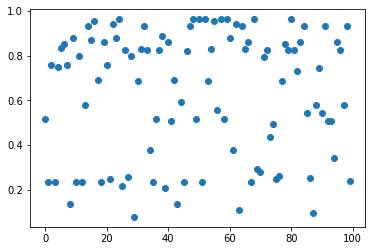

In [190]:
cases_df=X_test.sample(100, random_state=100)
proba_df=pd.DataFrame(gs_pipe.predict_proba(cases_df), index=cases_df.index, columns=['NOT_GUILTY_PROB','GUILTY_PROB'])
cases_df=pd.concat([proba_df, cases_df],axis=1)

plt.scatter(np.arange(len(cases_df)), cases_df['NOT_GUILTY_PROB'])


filter_df=cases_df.query('NOT_GUILTY_PROB > 0.4 and NOT_GUILTY_PROB < 0.6')[['NOT_GUILTY_PROB','MANEUVER', 'FIRST_CONTACT_POINT','FIRST_CRASH_TYPE']]


filter_df

In [176]:

nominal_cols=['AIRBAG_DEPLOYED',  'PHYSICAL_CONDITION', 'AGE_GROUP', 'VEHICLE_AGE', 
      'DRIVERS_LICENSE_CLASS','TRAFFICWAY_TYPE', 'SUN_GLARE' , 'ALIGNMENT' ,  
      'DEVICE_CONDITION','DRIVER_VISION', 'SAFETY_EQUIPMENT',  
      'ROAD_DEFECT', 'ROADWAY_SURFACE_COND', 'TRAFFIC_CONTROL_DEVICE', 'VEHICLE_DEFECT']


model_dic={}
print('Working with basic 3 cols')

nominal_columns=[ 'FIRST_CRASH_TYPE', 'FIRST_CONTACT_POINT', 'MANEUVER', 'TRAFFIC_CONTROL_DEVICE', 'PHYSICAL_CONDITION']
X_sel_train = X_train [nominal_columns] 
X_sel_test = X_test [nominal_columns]

gs_pipe.fit(X_sel_train, y_train)
y_pred_test=gs_pipe.predict(X_sel_test)
dic_key='XGB_base'
model_dic[dic_key]=gs_pipe
base_models_df = pd.DataFrame(columns=pd.DataFrame(model_dic['XGB_base'].cv_results_).columns)

model_df=pd.DataFrame(model_dic[dic_key].cv_results_)
model_df["Extra Columns"]=dic_key
base_models_df=pd.concat([model_df, base_models_df], axis=0 )


Working with basic 3 cols


KeyError: "['XGB_TRAFFIC_CONTROL_DEVICE', 'XGB_PHYSICAL_CONDITION'] not in index"

In [89]:
for col in nominal_cols : 
    nominal_columns=[ 'FIRST_CRASH_TYPE', 'FIRST_CONTACT_POINT', 'MANEUVER', 'TRAFFIC_CONTROL_DEVICE', 'PHYSICAL_CONDITION', col ]
    X_sel_train = X_train [nominal_columns] 
    X_sel_test = X_test [nominal_columns]
    print('---------------------')
    print ("Working with", col)

    cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(nominal_columns)),
        ('cat_encoder', OneHotEncoder(sparse=False, handle_unknown =  'ignore' )),
    ])


    fu = FeatureUnion(transformer_list=[
        ("cat_pipeline", cat_pipeline),
    ])


    XGB_pipeline = Pipeline([ ( 'fu', fu ),
                  ('boost', XGBClassifier(use_label_encoder=False, 
                                          eval_metric='auc', gamma= 0.02, max_depth=3, n_estimators=90, n_jobs=-1))
                 ])

    pipe_grid={'boost__gamma':[0.01,0.015]}

    gs_pipe = GridSearchCV(estimator=XGB_pipeline, param_grid=pipe_grid,  cv=3, scoring='roc_auc')
    
#    model_dic={}

    gs_pipe.fit(X_sel_train, y_train)
    y_pred_test=gs_pipe.predict(X_sel_test)
    
    dic_key=f'XGB_{col}'
    model_dic[dic_key]=gs_pipe


    
    model_df=pd.DataFrame(gs_pipe.cv_results_)
    model_df["Extra Columns"]=dic_key
    all_models_df=pd.concat([model_df, all_models_df], axis=0 )





Working with basic 3 cols
---------------------
Working with AIRBAG_DEPLOYED
---------------------
Working with PHYSICAL_CONDITION
---------------------
Working with AGE_GROUP
---------------------
Working with VEHICLE_AGE
---------------------
Working with DRIVERS_LICENSE_CLASS
---------------------
Working with TRAFFICWAY_TYPE
---------------------
Working with ALIGNMENT
---------------------
Working with WEATHER_CONDITION
---------------------
Working with LIGHTING_CONDITION
---------------------
Working with DEVICE_CONDITION
---------------------
Working with DRIVER_VISION
---------------------
Working with SAFETY_EQUIPMENT
---------------------
Working with ROAD_DEFECT
---------------------
Working with ROADWAY_SURFACE_COND
---------------------
Working with TRAFFIC_CONTROL_DEVICE
---------------------
Working with VEHICLE_DEFECT


In [90]:

all_models_df.sort_values(by='mean_test_score', ascending=False) 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_boost__gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,Extra Columns
1,0.239528,7.362942e-03,0.031240,1.520405e-06,0.015,{'boost__gamma': 0.015},0.850307,0.835504,0.845630,0.843814,0.006179,1,XGB_DRIVER_VISION
0,0.237414,4.375798e-03,0.026383,6.869543e-03,0.01,{'boost__gamma': 0.01},0.850307,0.835504,0.845630,0.843814,0.006179,1,XGB_DRIVER_VISION
0,0.229014,7.295409e-03,0.026036,7.362549e-03,0.01,{'boost__gamma': 0.01},0.851230,0.832867,0.843465,0.842521,0.007526,1,XGB_SAFETY_EQUIPMENT
1,0.229112,7.364066e-03,0.031241,1.030086e-06,0.015,{'boost__gamma': 0.015},0.851230,0.832867,0.843465,0.842521,0.007526,1,XGB_SAFETY_EQUIPMENT
0,0.236715,1.577995e-02,0.020828,7.362998e-03,0.01,{'boost__gamma': 0.01},0.848776,0.833497,0.844992,0.842422,0.006497,1,XGB_AIRBAG_DEPLOYED
1,0.234320,1.325077e-06,0.026034,7.364628e-03,0.015,{'boost__gamma': 0.015},0.848776,0.833497,0.844992,0.842422,0.006497,1,XGB_AIRBAG_DEPLOYED
0,0.241030,1.589618e-02,0.023599,6.381495e-03,0.01,{'boost__gamma': 0.01},0.849988,0.833091,0.843299,0.842126,0.006948,1,XGB_DEVICE_CONDITION
0,0.290066,6.555638e-03,0.031242,1.408263e-06,0.01,{'boost__gamma': 0.01},0.850147,0.831394,0.844797,0.842113,0.007888,1,XGB_PHYSICAL_CONDITION
0,0.321448,6.603885e-03,0.020827,7.363504e-03,0.01,{'boost__gamma': 0.01},0.850147,0.831394,0.844797,0.842113,0.007888,1,XGB_TRAFFIC_CONTROL_DEVICE
0,0.233228,1.144377e-02,0.026035,7.363055e-03,0.01,{'boost__gamma': 0.01},0.849108,0.832602,0.843916,0.841876,0.006891,1,XGB_ROAD_DEFECT


In [75]:
import joblib
import pickle
import sklearn

joblib_file='XGB_models.pkl'
pkl_file_name='XGB_models.pikle'

joblib.dump(model_dic, joblib_file)

with open (pkl_file_name, 'wb') as file:
    pickle.dump(model_dic, file)
    
    